In [109]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Suppress warnings for now
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
pd.pandas.set_option('display.max_columns', None)  # remove limits on no. of cols displayed

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

from sklearn.preprocessing import FunctionTransformer

In [110]:
# load dataset
data = pd.read_csv('/home/padmac/datasets/houseprice/houseprice.csv')
data.shape

(1460, 81)

In [111]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [112]:
# Load the actual test.csv (provided by the competition)
test_df = pd.read_csv('/home/padmac/datasets/houseprice/test.csv')
test_df.shape

(1459, 80)

In [114]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [115]:
# EDA
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

## Visualizations

Text(0, 0.5, 'No. of distict values')

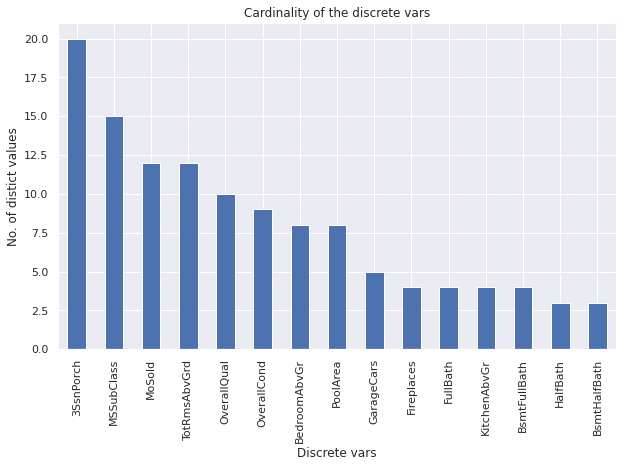

In [145]:
# plot the no. of unique values in each of the discrete vars
data[discrete].nunique().sort_values(ascending=False).plot.bar(figsize=(10,6))
plt.title('Cardinality of the discrete vars')
#plt.xticks(rotation=45)
plt.xlabel('Discrete vars')
plt.ylabel('No. of distict values')

Text(0, 0.5, 'No. of distict values')

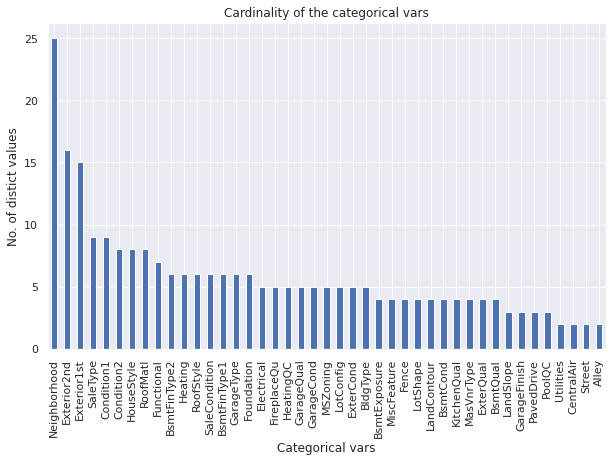

In [146]:
# plot the number of unique values in the categorical vars ( DESCENDING order)
data[categorical].nunique().sort_values(ascending=False).plot.bar(figsize=((10,6)))
plt.title('Cardinality of the categorical vars')
#plt.xticks(rotation=0)
plt.xlabel('Categorical vars')
plt.ylabel('No. of distict values')

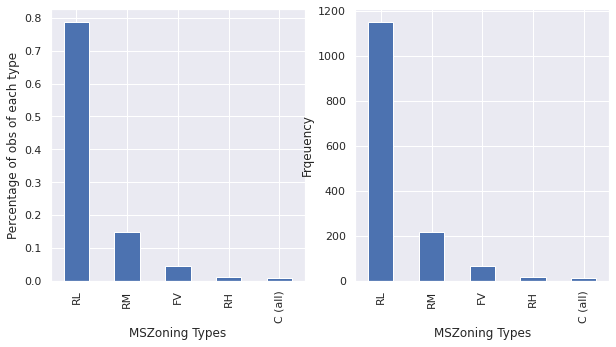

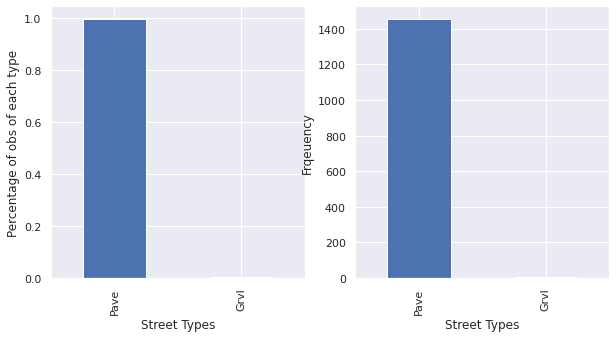

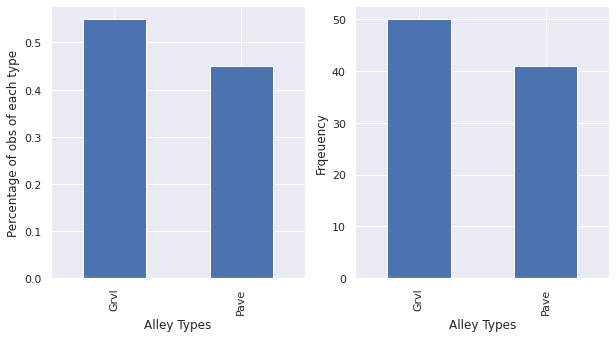

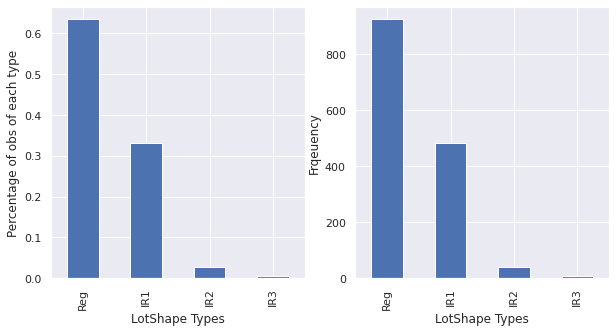

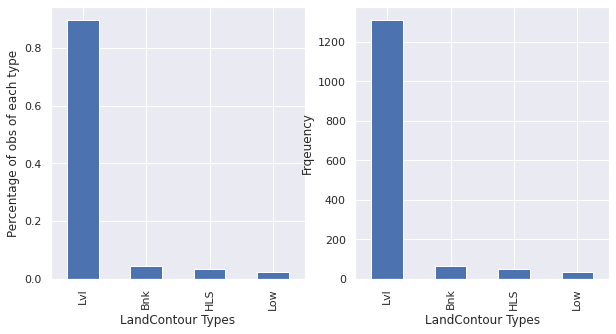

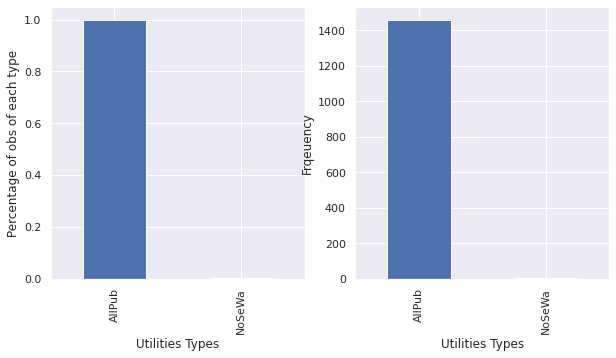

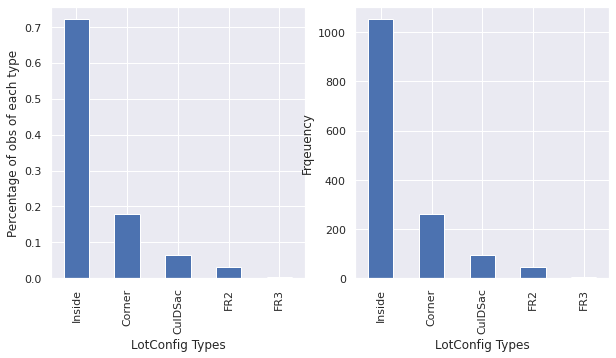

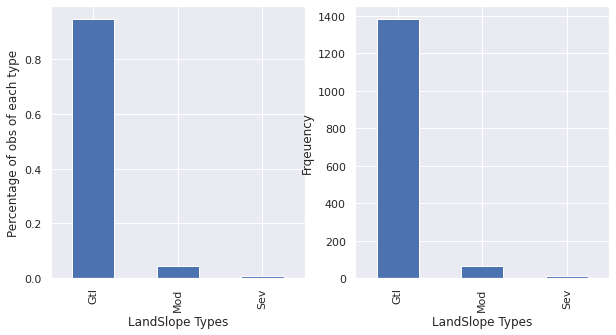

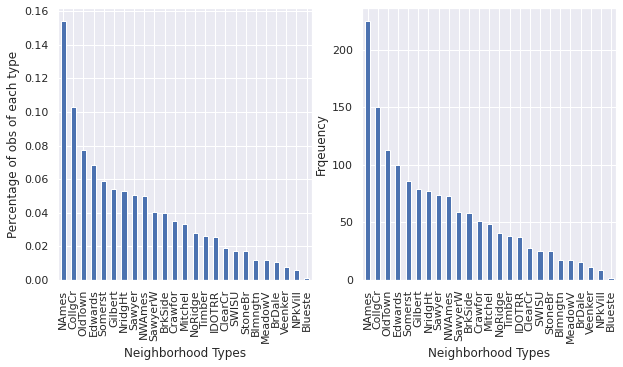

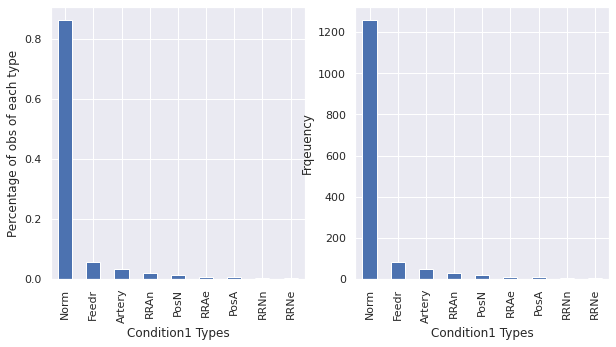

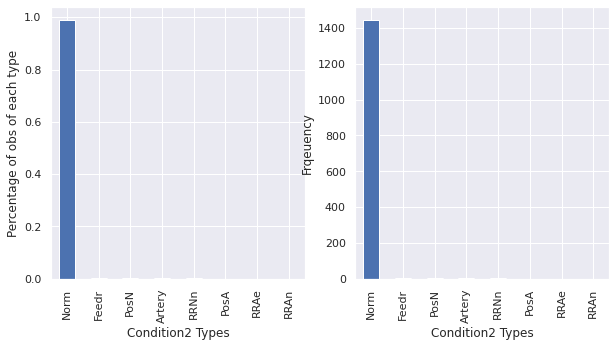

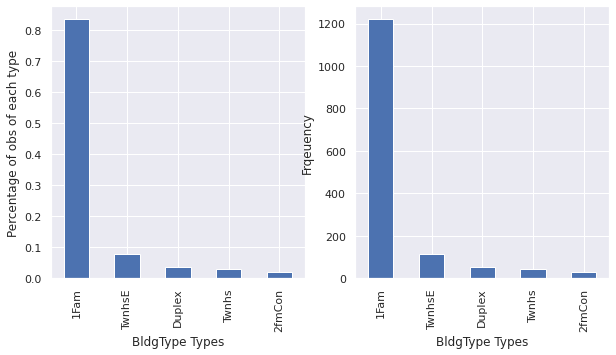

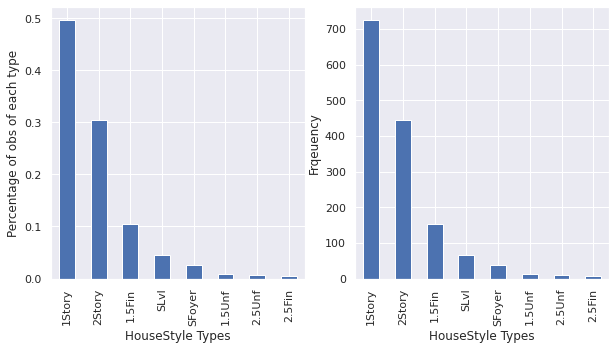

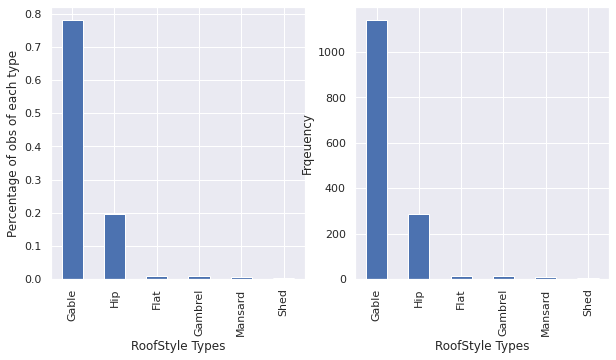

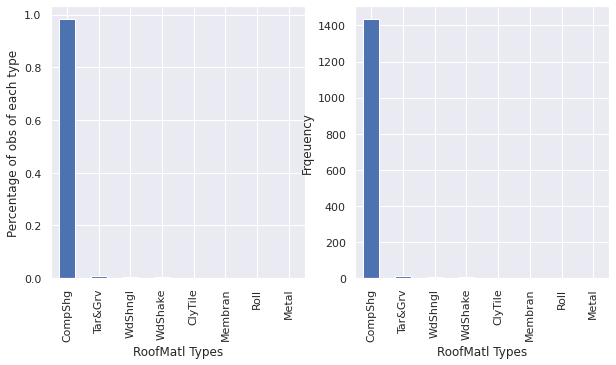

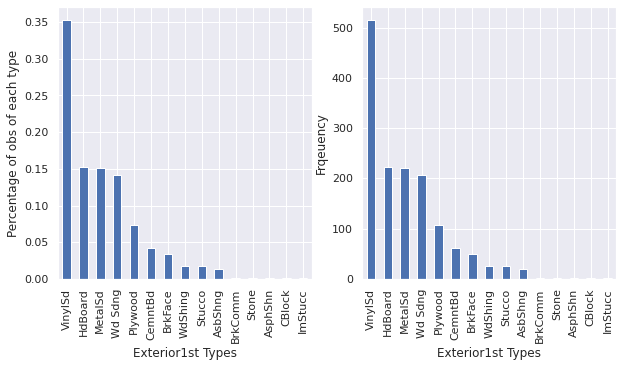

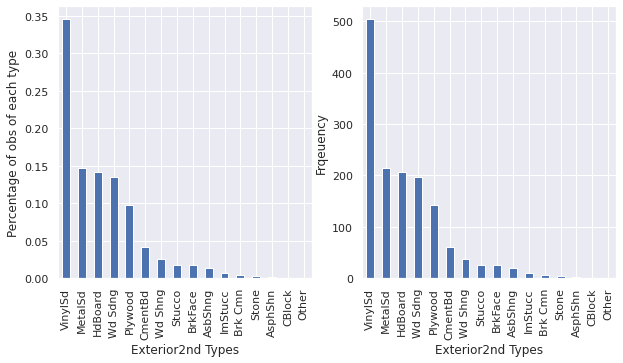

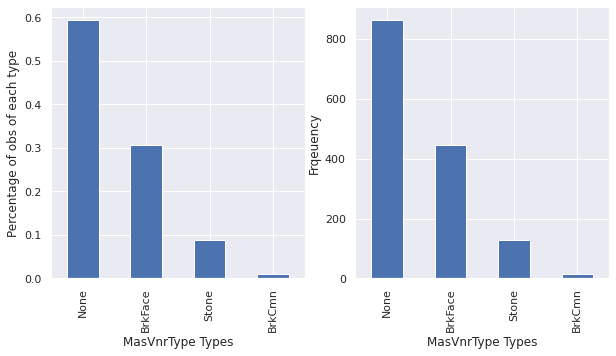

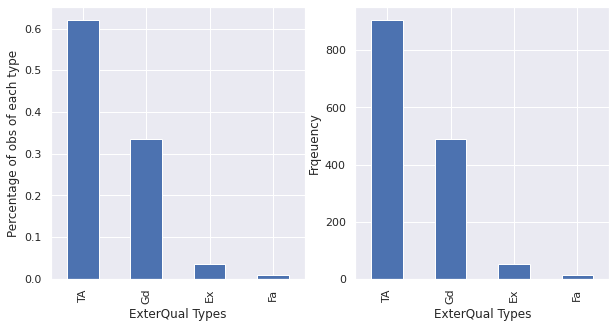

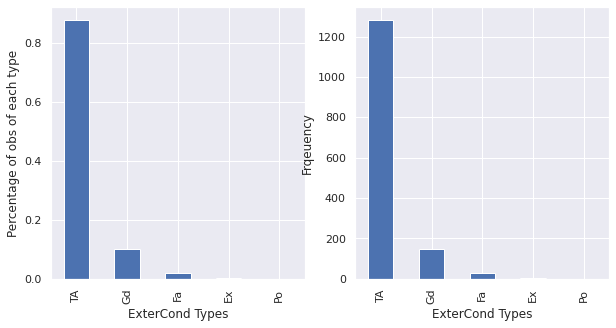

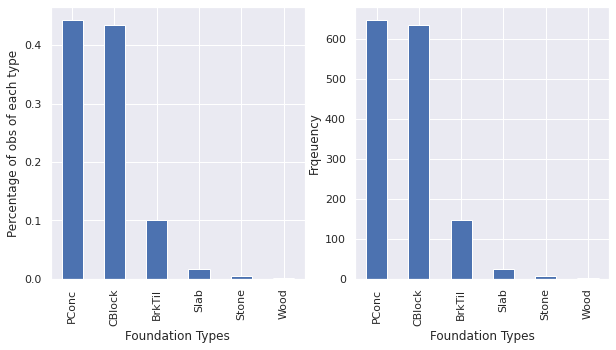

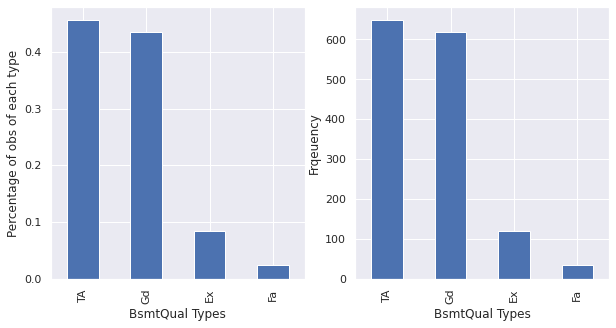

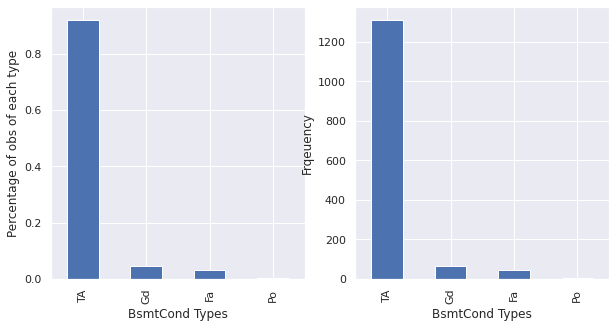

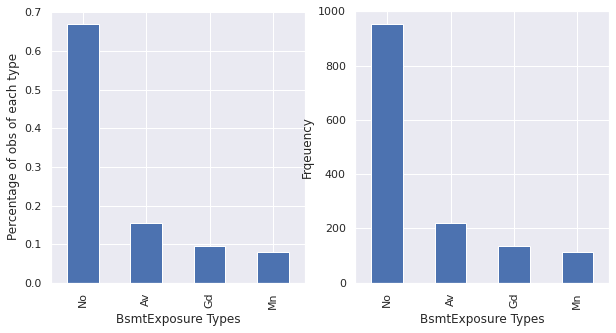

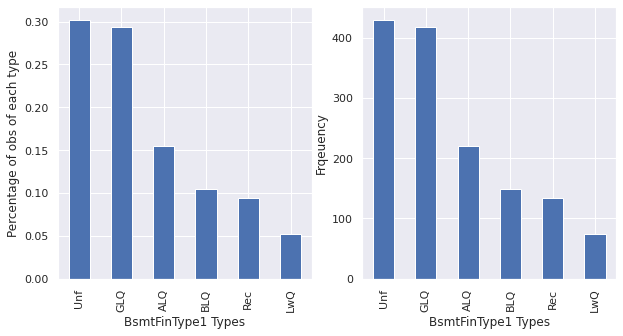

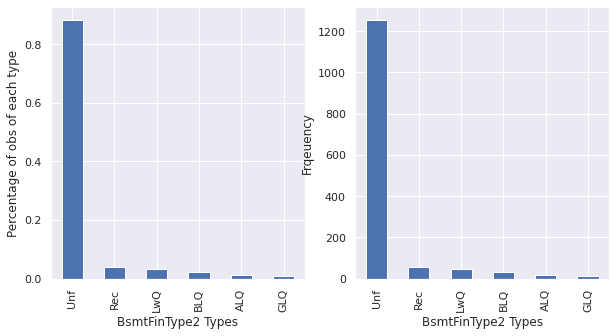

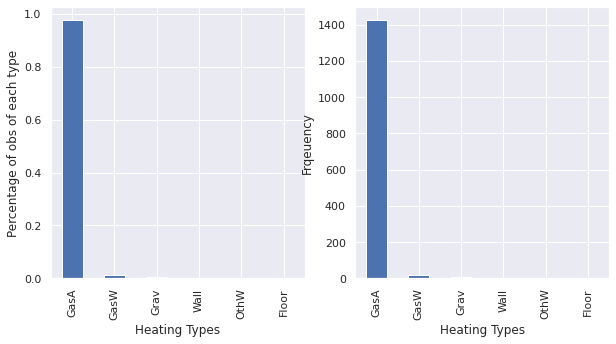

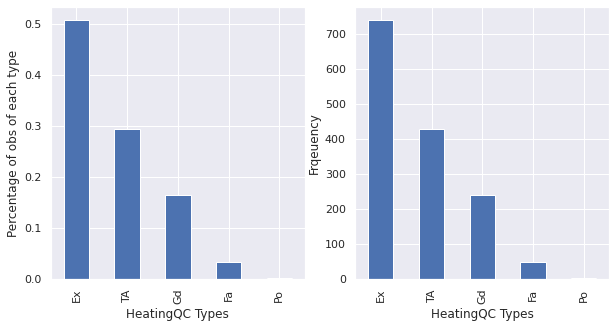

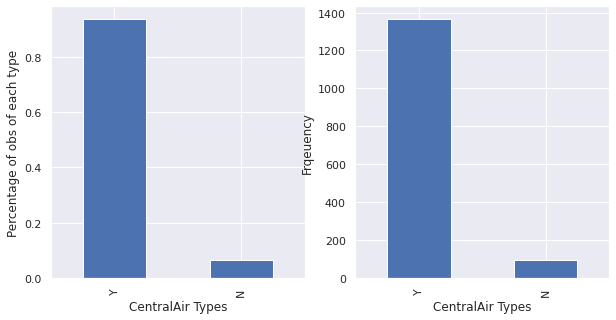

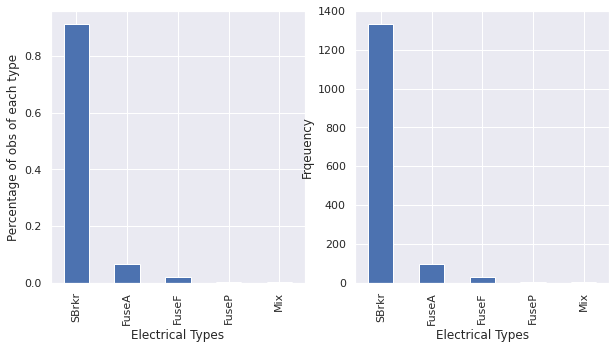

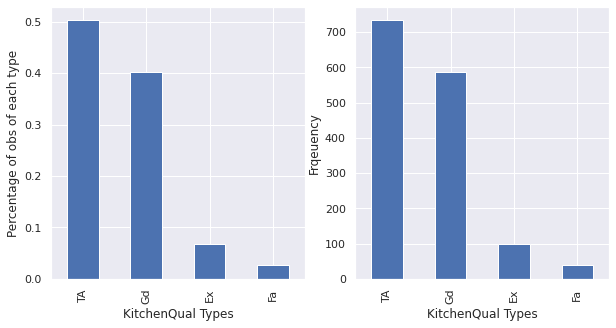

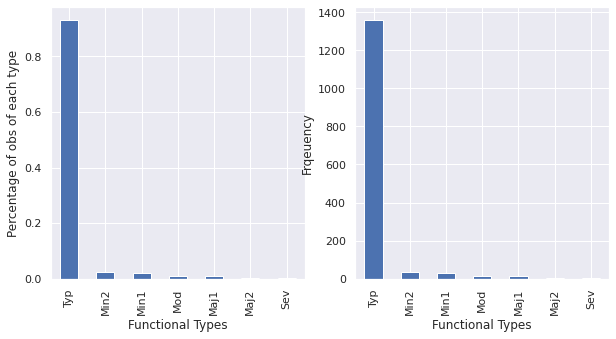

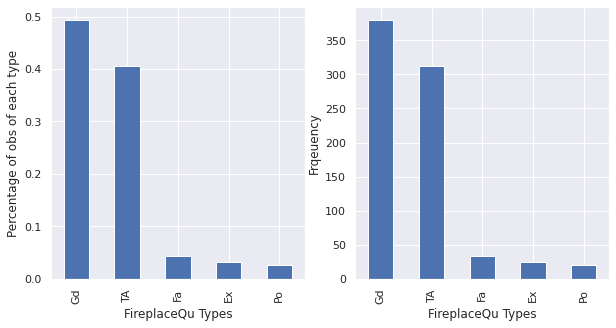

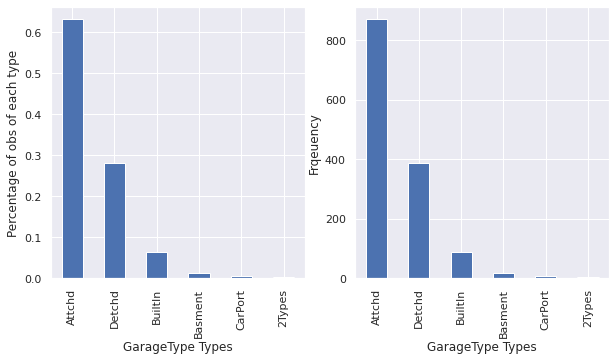

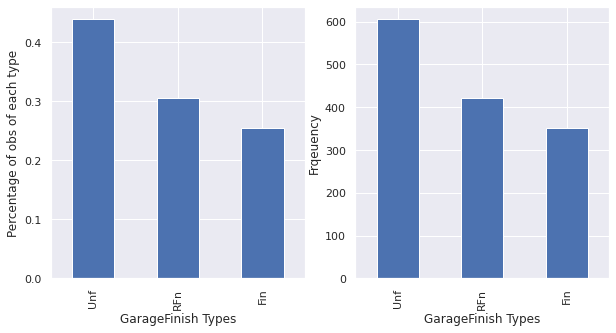

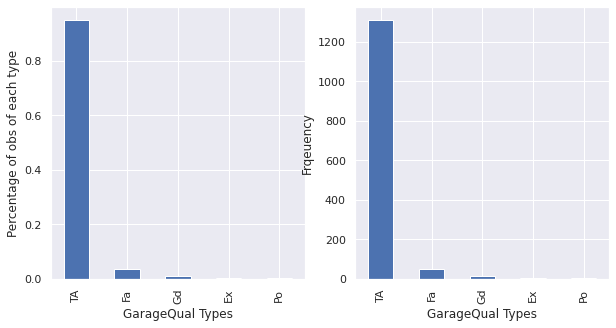

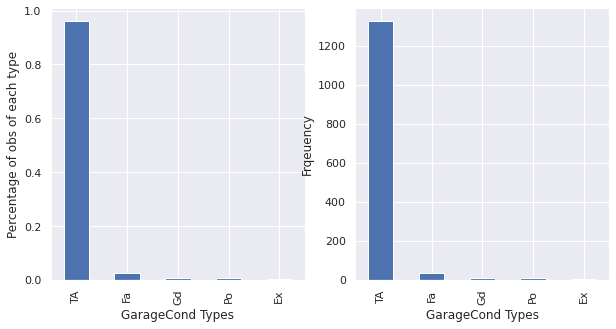

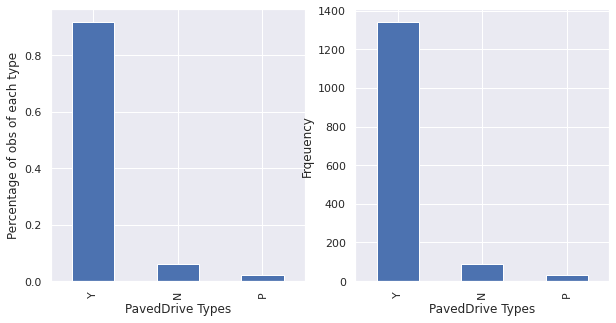

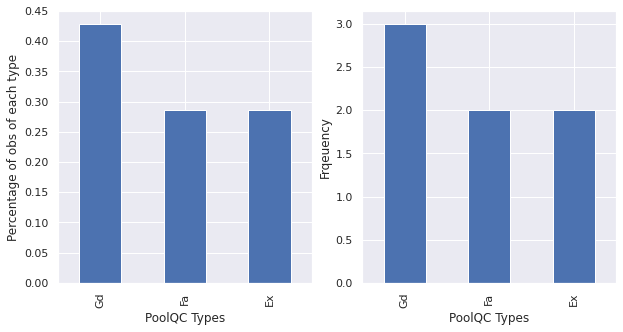

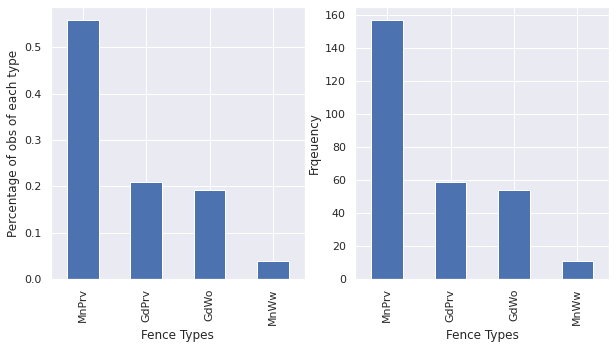

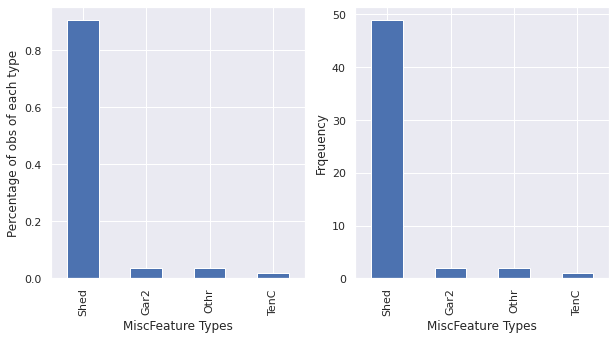

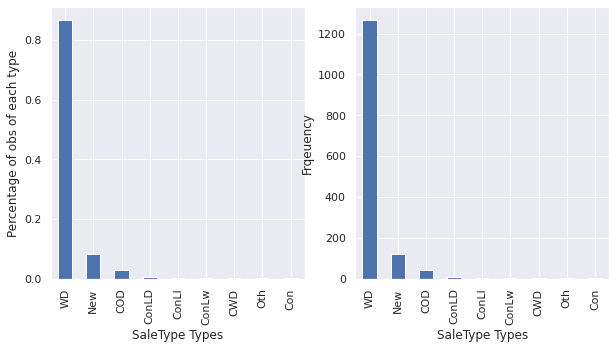

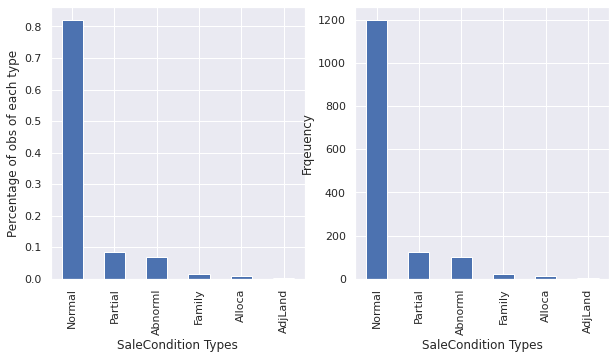

In [147]:
i=0
for var in categorical:
    vcounts = data[var].value_counts()
    vtotal = data[var].notnull().sum()
    percent = vcounts/np.float(vtotal)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    
    (vcounts/np.float(vtotal)).plot.bar()
    plt.xlabel(var + ' Types')
    plt.ylabel('Percentage of obs of each type')
    
    plt.subplot(1,2,2)
    
    data[var].value_counts().plot.bar()
    plt.xlabel(var + ' Types')
    plt.ylabel('Frqeuency')
    i += 1
    plt.show()
   

In [148]:
data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

#### Outliers in continuous vars

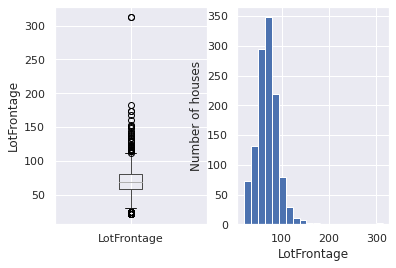

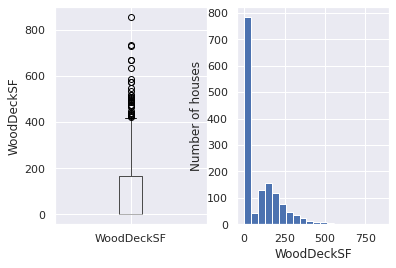

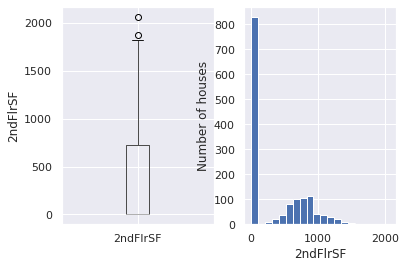

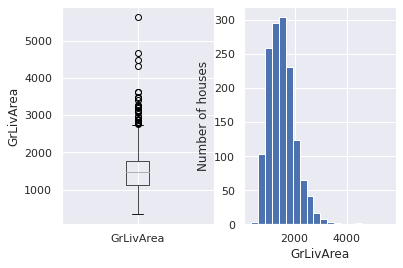

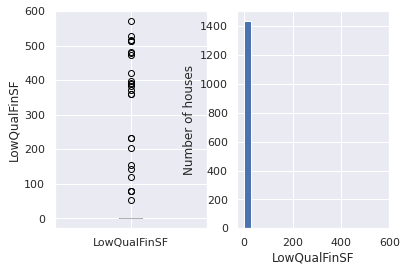

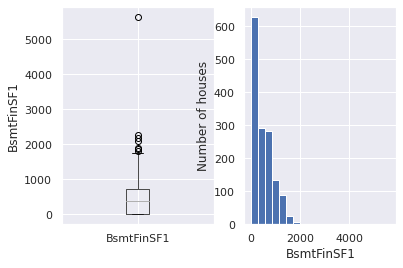

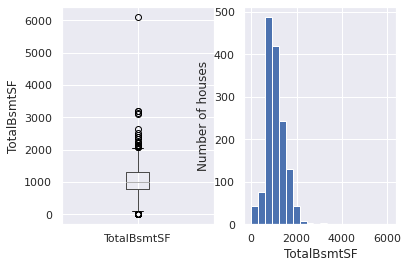

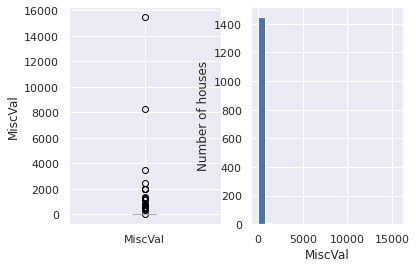

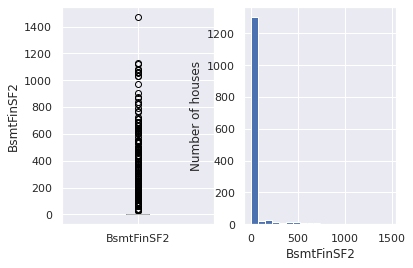

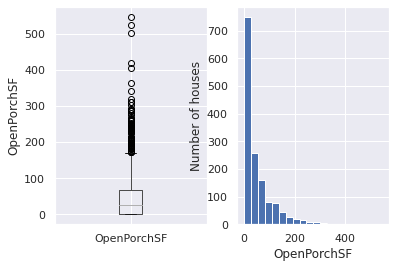

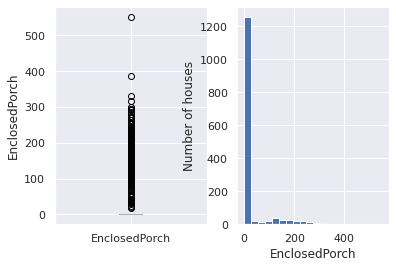

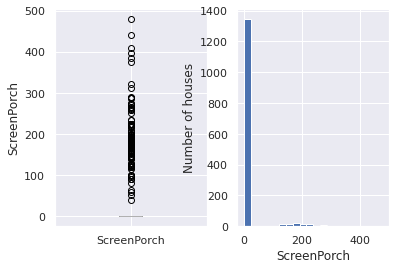

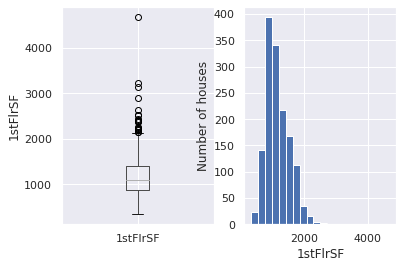

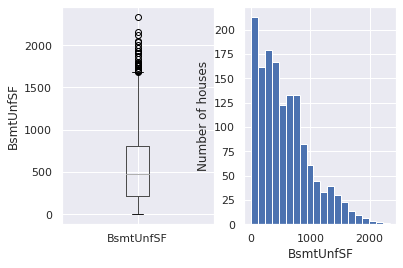

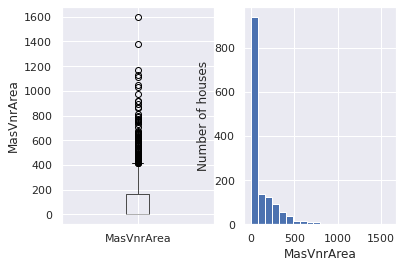

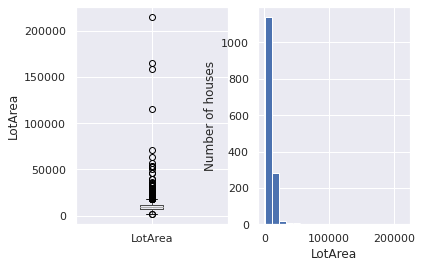

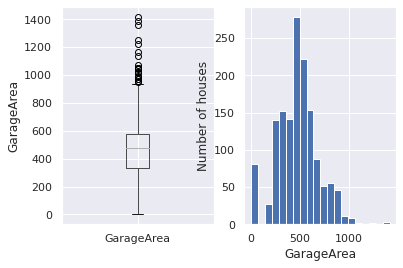

In [149]:
for var in continuous:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

#### Outliers in discrete vars

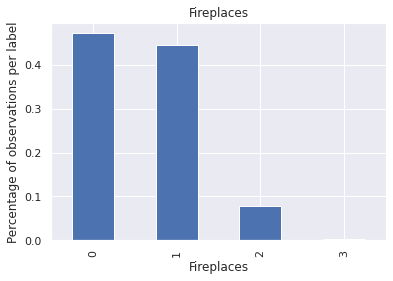

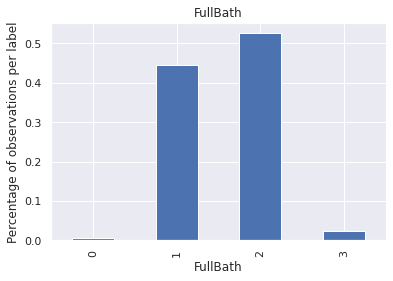

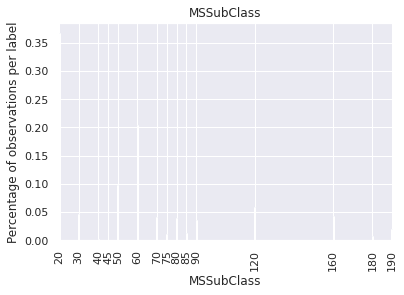

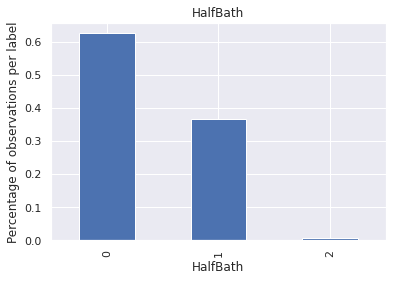

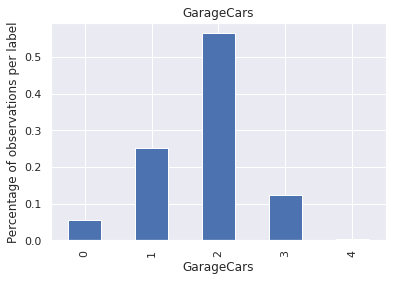

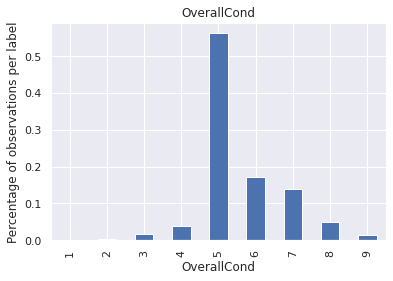

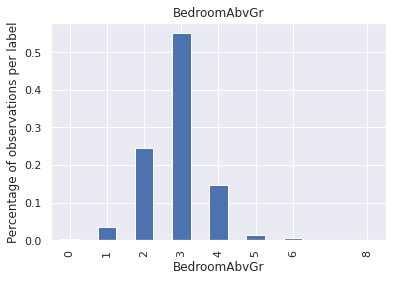

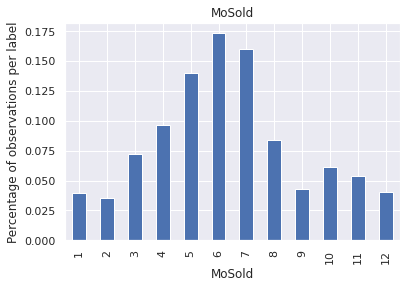

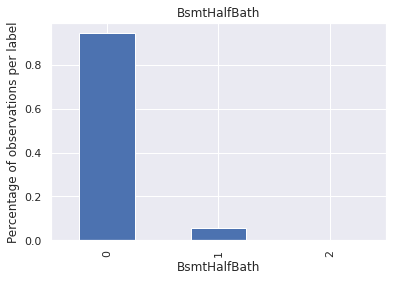

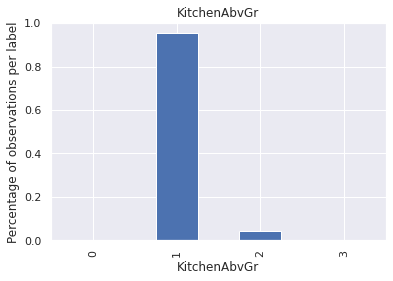

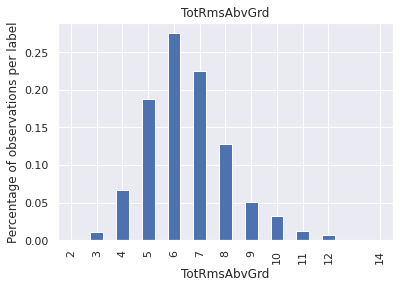

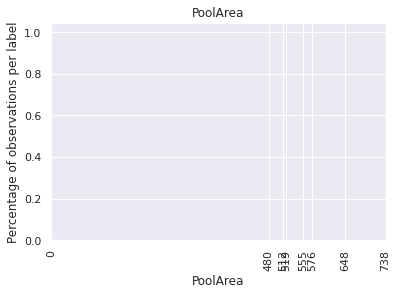

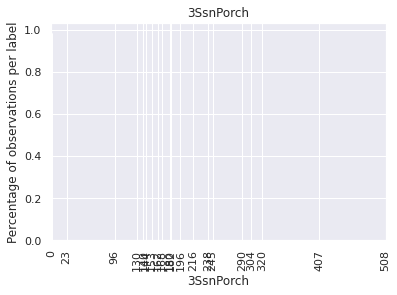

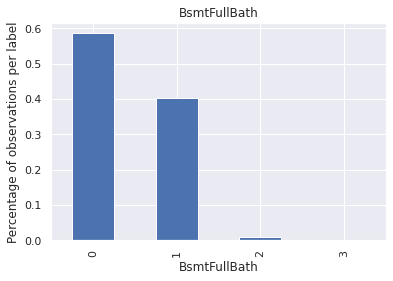

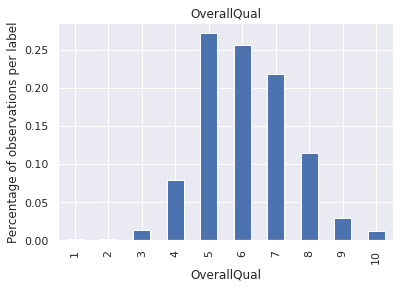

In [150]:
for var in discrete:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar() # (A)
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

In [29]:
# Data Wrangling

In [117]:
numerical = data.select_dtypes(exclude='O').columns.to_list()
categorical = data.select_dtypes(include='O').columns.to_list()

### Find all columns which have 'Year' or 'Yr' in their names (case-insensitive)

regex = "(Year|Yr)" # <--- Note : NOT SQUARE brackets when matching words !!!
tmp = data.columns.str.contains(regex, case=False)  #<--case INSENSTIVE match in a Pandas Series


yr_cols = data.columns[tmp].to_list()
yr_cols

tmp = list(set(numerical) - set(yr_cols))
numerical = tmp

discrete = [var for var in numerical if data[var].nunique() <= 20]


continuous = list(set(numerical) - set(discrete))
continuous.remove('Id')
continuous.remove('SalePrice')

new_cols = continuous + discrete + categorical + yr_cols
len(new_cols)

new_df = data[new_cols]

new_df.head()

for col in categorical:
    mcount = new_df[col].isnull().sum()
    percent = mcount/len(new_df)
    if mcount > 0:
        print('{} missing {} percentage: {}'.format(col, mcount, percent))

Alley missing 1369 percentage: 0.9376712328767123
MasVnrType missing 8 percentage: 0.005479452054794521
BsmtQual missing 37 percentage: 0.025342465753424658
BsmtCond missing 37 percentage: 0.025342465753424658
BsmtExposure missing 38 percentage: 0.026027397260273973
BsmtFinType1 missing 37 percentage: 0.025342465753424658
BsmtFinType2 missing 38 percentage: 0.026027397260273973
Electrical missing 1 percentage: 0.0006849315068493151
FireplaceQu missing 690 percentage: 0.4726027397260274
GarageType missing 81 percentage: 0.05547945205479452
GarageFinish missing 81 percentage: 0.05547945205479452
GarageQual missing 81 percentage: 0.05547945205479452
GarageCond missing 81 percentage: 0.05547945205479452
PoolQC missing 1453 percentage: 0.9952054794520548
Fence missing 1179 percentage: 0.8075342465753425
MiscFeature missing 1406 percentage: 0.963013698630137


In [118]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [119]:
for var in yr_cols:
    new_df = elapsed_years(new_df, var)

/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [120]:
for var in yr_cols:
    new_test_df = elapsed_years(test_df, var)

In [121]:
new_df.drop('YrSold', axis=1, inplace=True)
new_test_df.drop('YrSold', axis=1, inplace=True)


/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [122]:
#drop_cols = ['Alley', 'PoolQC', 'Fence']
#new_df = new_df.drop(columns = drop_cols, axis=1)
#new_test_df = new_test_df.drop(columns = drop_cols, axis=1)

In [123]:
newcol2 = new_df.columns
len(newcol2)

78

In [124]:
new_test_df.drop('Id', axis=1, inplace=True)
new_test_cols = new_test_df.columns
len(new_test_cols)

78

In [125]:
X_train, X_test, y_train, y_test = train_test_split(new_df,
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 78), (146, 78))

In [126]:
yr_cols.remove('YrSold')

In [127]:
X_train.head()

,LotFrontage,WoodDeckSF,2ndFlrSF,GrLivArea,LowQualFinSF,BsmtFinSF1,TotalBsmtSF,MiscVal,BsmtFinSF2,OpenPorchSF,EnclosedPorch,ScreenPorch,1stFlrSF,BsmtUnfSF,MasVnrArea,LotArea,GarageArea,Fireplaces,FullBath,MSSubClass,HalfBath,GarageCars,OverallCond,BedroomAbvGr,MoSold,BsmtHalfBath,KitchenAbvGr,TotRmsAbvGrd,PoolArea,3SsnPorch,BsmtFullBath,OverallQual,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearBuilt,YearRemodAdd,GarageYrBlt
930,73.0,100,0,1466,0,16,1466,0,0,18,0,0,1466,1450,0.0,8925,610,0,2,20,0,3,5,3,7,0,1,7,0,0,0,8,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal,2,2,2.0
656,72.0,0,0,1053,0,806,1053,0,0,0,0,0,1053,247,54.0,10007,312,0,1,20,1,1,7,3,8,0,1,5,0,0,1,5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,49,2,49.0
45,61.0,196,0,1752,0,456,1752,0,0,82,0,0,1752,1296,412.0,7658,576,1,2,120,0,2,5,2,2,0,1,6,0,0,1,9,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,Ex,TA,PConc,Ex,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,5,5,5.0
1348,NaN,402,0,1494,0,1443,1482,0,0,25,0,0,1494,39,0.0,16196,514,1,2,20,0,2,5,3,8,0,1,5,0,0,1,7,RL,Pave,NaN,IR3,Low,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Fa,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,9,9,9.0
55,100.0,0,0,1425,0,490,1425,0,0,0,0,0,1425,935,272.0,10175,576,1,2,20,0,2,5,3,7,0,1,7,0,407,0,6,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,Plywood,BrkFace,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,44,44,44.0


In [128]:
import itertools
def flatten(list2d):
    merged = list(itertools.chain.from_iterable(list2d))
    return merged

In [129]:
# treat discrete variables like categorical; 
# so we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
new_test_df[discrete] = new_test_df[discrete].astype('O')

/home/padmac/anaconda3/envs/nltk/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [130]:
X_train[newcol2].head()

,LotFrontage,WoodDeckSF,2ndFlrSF,GrLivArea,LowQualFinSF,BsmtFinSF1,TotalBsmtSF,MiscVal,BsmtFinSF2,OpenPorchSF,EnclosedPorch,ScreenPorch,1stFlrSF,BsmtUnfSF,MasVnrArea,LotArea,GarageArea,Fireplaces,FullBath,MSSubClass,HalfBath,GarageCars,OverallCond,BedroomAbvGr,MoSold,BsmtHalfBath,KitchenAbvGr,TotRmsAbvGrd,PoolArea,3SsnPorch,BsmtFullBath,OverallQual,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearBuilt,YearRemodAdd,GarageYrBlt
930,73.0,100,0,1466,0,16,1466,0,0,18,0,0,1466,1450,0.0,8925,610,0,2,20,0,3,5,3,7,0,1,7,0,0,0,8,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal,2,2,2.0
656,72.0,0,0,1053,0,806,1053,0,0,0,0,0,1053,247,54.0,10007,312,0,1,20,1,1,7,3,8,0,1,5,0,0,1,5,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal,49,2,49.0
45,61.0,196,0,1752,0,456,1752,0,0,82,0,0,1752,1296,412.0,7658,576,1,2,120,0,2,5,2,2,0,1,6,0,0,1,9,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,Ex,TA,PConc,Ex,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,5,5,5.0
1348,NaN,402,0,1494,0,1443,1482,0,0,25,0,0,1494,39,0.0,16196,514,1,2,20,0,2,5,3,8,0,1,5,0,0,1,7,RL,Pave,NaN,IR3,Low,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Fa,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,9,9,9.0
55,100.0,0,0,1425,0,490,1425,0,0,0,0,0,1425,935,272.0,10175,576,1,2,20,0,2,5,3,7,0,1,7,0,407,0,6,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,Plywood,BrkFace,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,44,44,44.0


In [131]:
new_test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,49,49,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,49.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,52,52,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,52.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,13,12,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,13.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,12,12,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,12.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,18,18,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,18.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,WD,Normal


In [132]:
dc_combined = discrete + categorical
#for col in drop_cols:
#    dc_combined.remove(col)

In [133]:
is_obj = lambda z: z.dtype == 'O'
X_train[dc_combined].apply(is_obj).all()

True

In [134]:
new_test_df[dc_combined].apply(is_obj).all()

True

In [135]:
def get_stacking():
    level0 = []
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('cart', DecisionTreeRegressor(random_state=42)))
    level0.append(('svm', SVR())) # doesn't take random_state
    level0.append(('rf', RandomForestRegressor(random_state=42)))
    level0.append(('lgbm', LGBMRegressor(random_state=42)))
    level0.append(('xgb', XGBRegressor(random_state=42)))
    
    # define meta learner model
    level1 = XGBRegressor(random_state=42)
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=15, passthrough=True)
    return model

In [136]:
def drop_rows_with_nans(tmpX):
    tmp_df = pd.DataFrame(tmpX)
    tmp_df.dropna(inplace=True)
    return tmp_df.values

In [137]:
def replace_nans_with_zero(tmpX):
    tmp_df = pd.DataFrame(tmpX)
    tmp_df.fillna(0, inplace=True)
    return tmp_df.values

In [138]:
stacked_pipe = Pipeline([

    # missing data imputation
    ('missing_ind', mdi.AddMissingIndicator(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=continuous+yr_cols)),
    
    ('imputer_cat', mdi.CategoricalImputer(return_object=True, imputation_method='frequent',
                                           variables=dc_combined)),

    # categorical encoding
    ('rare_label_enc', ce.RareLabelEncoder(
       tol=0.05, n_categories=6, variables=dc_combined)),
    
    ('categorical_enc', ce.OrdinalEncoder(
       encoding_method='ordered', variables=dc_combined)),

    # discretisation + encoding
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=continuous)),
    
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=continuous)),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    # replacing any nas with 0
    ('replace_nans', FunctionTransformer(replace_nans_with_zero, validate=False)),

    # regression
    #('lasso', Lasso(random_state=0))
    ('stk_model', get_stacking())
])

In [139]:
stacked_pipe.fit(X_train, y_train)

[01:50:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

Pipeline(steps=[('missing_ind',
                 AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'WoodDeckSF',
                                              '2ndFlrSF', 'GrLivArea',
                                              'LowQualFinSF', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'MiscVal',
                                              'BsmtFinSF2', 'OpenPorchSF',
                                              'EnclosedPorch', 'ScreenPorch',
                                              '1stFlrSF', 'BsmtUnfSF',
                                              'MasVnrArea', 'LotA...
                 FunctionTransformer(func=<function replace_nans_with_zero at 0x7f6e44713680>)),
                ('stk_model',
                 StackingRegressor(cv=15,
                                   es

In [140]:
X_train_preds = stacked_pipe.predict(X_train)
X_test_preds = stacked_pipe.predict(X_test)

In [141]:
# check model performance:
from sklearn.metrics import mean_squared_log_error

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
RMSLE = np.sqrt( mean_squared_log_error(y_train, X_train_preds) )
print('test RMSLE score: {}'.format(RMSLE))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))
RMSLE = np.sqrt( mean_squared_log_error(y_test, X_test_preds) )
print('test RMSLE score: {}'.format(RMSLE))

train mse: 299628131.44041485
train rmse: 17309.769826326832
train r2: 0.952012139762374
test RMSLE score: 0.07575853334941299

test mse: 653400552.8915954
test rmse: 25561.700899814852
test r2: 0.904920024528557
test RMSLE score: 0.11868122924571226


In [142]:
subm_preds = stacked_pipe.predict(new_test_df)

In [143]:
subm_preds.shape

(1459,)

In [144]:
#===========================================================================
# write out CSV submission file
#===========================================================================
sample_submission = pd.read_csv('/home/padmac/udemy/feature_engg/dataset_house/sample_submission.csv')
output = pd.DataFrame({"Id":sample_submission.Id, "SalePrice":subm_preds})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,205430.468750
1,1462,229484.578125
2,1463,248323.640625
3,1464,219302.921875
4,1465,188458.875000
